### Install project

In [1]:
!git clone https://github.com/kornelro/cv_project.git

Cloning into 'cv_project'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 433 (delta 51), reused 117 (delta 32), pack-reused 278
Receiving objects: 100% (433/433), 96.24 MiB | 37.13 MiB/s, done.
Resolving deltas: 100% (197/197), done.


In [2]:
!pip install cv_project/.

Processing ./cv_project
  Created wheel for src: filename=src-0.1.0-cp36-none-any.whl size=14757 sha256=08354b2699efff2ad71a352af0895c84e916357b84917770dac90b9c432285e3
  Stored in directory: /tmp/pip-ephem-wheel-cache-1sknfn_j/wheels/fc/1b/40/72379bece2bafba26136079aeac87421c9221abafeb9c66746
Successfully built src


### Mount drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DRIVE_PATH = '/content/drive/Shareddrives/CV-PROJECT/'

### Imports

In [5]:
pip install stellargraph

     |████████████████████████████████| 440kB 6.2MB/s 


In [7]:
import pickle
import numpy as np
import tensorflow.keras as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from stellargraph.utils.history import plot_history

from src.data.make_dataset import make_dataset
from src.data.image_loaders import AerialCarsFixedSizeImageLoader
from src.data.dataset_loaders import AerialCarsDatasetLoader
from src.features.pipelines import RawImageToImage
from src.features.processors import NormImage, EqualHist
from src.models.classifiers import ResnetModelWrapper
from src.models.detectors import SliderProbDetector
from src.data.sliders import SlidingWindow

# Aerial-Cars-Dataset
# ResNet50
# Pipeline: EqualHist, Norm

### Load dataset

In [10]:
DATA_PATH = DRIVE_PATH+'data/processed/aerial-cars-dataset/resnet/data_resnet_eqhist.pickle'

In [11]:
with open(DATA_PATH, 'rb') as f:
    data = pickle.load(f)

### Train ResNet50

In [12]:
TEST_SIZE = 0.1
BATCH_SIZE = 100
EPOCHS = 5

In [13]:
X = np.array(list(map(lambda x: x[1], data)))
y = np.array(list(map(lambda x: x[2], data)))
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=42
  )


input_t = K.Input(shape=(X[0].shape))
res_model = K.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_tensor=input_t
)

for layer in res_model.layers:
    layer.trainable = False

model = K.models.Sequential()
model.add(res_model)
model.add(K.layers.Flatten())
model.add(K.layers.Dense(2, activation='softmax'))


model.compile(
    optimizer=K.optimizers.Adam(0.001),
    loss=K.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(X_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS, 
            validation_data=(X_test, y_test)
)

94674944/94668760 [==============================] - 1s 0us/step
Epoch 1/5
43/43 [==============================] - 14s 91ms/step - loss: 0.3363 - accuracy: 0.9116 - val_loss: 0.1294 - val_accuracy: 0.9767
Epoch 2/5
43/43 [==============================] - 2s 50ms/step - loss: 0.0512 - accuracy: 0.9912 - val_loss: 0.1073 - val_accuracy: 0.9831
Epoch 3/5
43/43 [==============================] - 2s 50ms/step - loss: 0.0157 - accuracy: 0.9958 - val_loss: 0.1260 - val_accuracy: 0.9831
Epoch 4/5
43/43 [==============================] - 2s 51ms/step - loss: 0.0025 - accuracy: 0.9994 - val_loss: 0.1104 - val_accuracy: 0.9873
Epoch 5/5
43/43 [==============================] - 2s 51ms/step - loss: 9.3478e-04 - accuracy: 1.0000 - val_loss: 0.1192 - val_accuracy: 0.9809


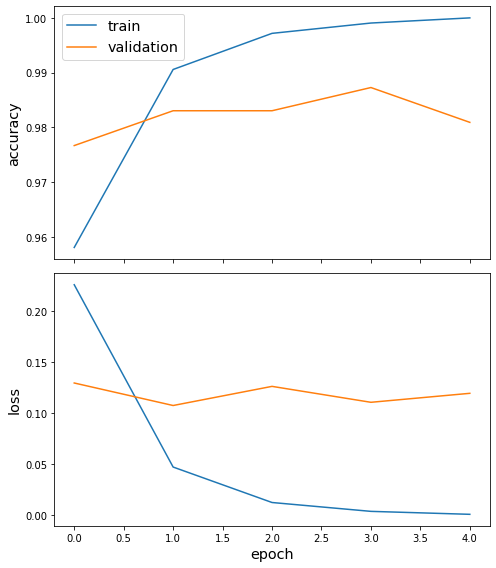

In [14]:
plot_history(history)

### Validation

In [15]:
from tqdm import tqdm
from copy import deepcopy

def validate_model(
    dataset_loader,
    input_folder_filepath,
    images_files_types,
    annotations_files_types,
    detector,
    workers = 0
):

    images = dataset_loader.load_dataset(
        input_folder_filepath,
        images_files_types,
        annotations_files_types,
        False
    )

    processed_images = []

    for image in tqdm(images):
        processed_images.append(
            detector(deepcopy(image), workers)
        )

    return processed_images

In [16]:
data = None

In [17]:
BND_BOX_SIZE = (80, 80)
STEP_SIZE = 20

dataset_loader = AerialCarsDatasetLoader(
    image_loader=AerialCarsFixedSizeImageLoader(
        bnd_box_size=BND_BOX_SIZE
    )
)

process_pipeline=RawImageToImage(
    processors=[
        EqualHist(),
        NormImage()
    ]
)

sliding_window = SlidingWindow(
    step_size=STEP_SIZE,
    window_size=BND_BOX_SIZE
)

slider_detector = SliderProbDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ResnetModelWrapper(model),
    treshold=0.9,
    nms_overlap=0.3
)

In [18]:
processed_images = validate_model(
    dataset_loader=dataset_loader,
    input_folder_filepath=DRIVE_PATH+'data/raw/aerial-cars-dataset/val_dev',
    images_files_types=('jpg', 'JPG', 'png'),
    annotations_files_types=('txt',),
    detector=slider_detector,
    workers=0
)

  0%|          | 0/1 [00:00<?, ?it/s]

(202, 80, 80, 3)
(202, 80, 80, 3)
(202, 80, 80, 3)
(202, 80, 80, 3)
(202, 80, 80, 3)
(202, 80, 80, 3)
(202, 80, 80, 3)
(202, 80, 80, 3)
(202, 80, 80, 3)
(202, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)
(201, 80, 80, 3)


100%|██████████| 1/1 [00:07<00:00,  7.09s/it]

206
Overlap is 0.19524462734339276
Overlap is 0.7530864197530864
Overlap is 0.3811918914799573
Overlap is 0.13122999542752628
Overlap is 0.19524462734339276
Overlap is 0.06721536351165981
Overlap is 0.3811918914799573
Overlap is 0.19524462734339276
Overlap is 0.2562109434537418
Overlap is 0.13122999542752628
Overlap is 0.25925925925925924
Overlap is 0.3811918914799573
Overlap is 0.012345679012345678
Overlap is 0.009297363206828228
Overlap is 0.7530864197530864
Overlap is 0.5061728395061729
Overlap is 0.25925925925925924
Overlap is 0.5671391556165218
Overlap is 0.5671391556165218
Overlap is 0.3811918914799573
Overlap is 0.19524462734339276
Overlap is 0.7530864197530864
Overlap is 0.3811918914799573
Overlap is 0.19524462734339276
Overlap is 0.7530864197530864
Overlap is 0.5671391556165218
Overlap is 0.5061728395061729
Overlap is 0.7530864197530864
Overlap is 0.3811918914799573
Overlap is 0.2562109434537418
Overlap is 0.5061728395061729
Overlap is 0.19524462734339276
Overlap is 0.38119189

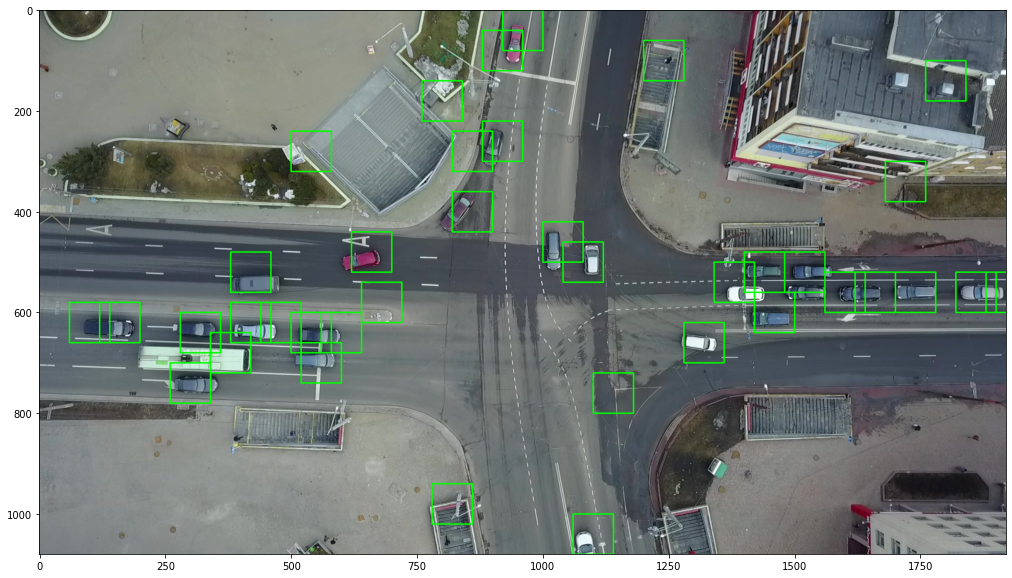

In [19]:
plt.figure(figsize=(20,10))
plt.imshow(processed_images[0][0])